In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import albumentations as A
import time

# Generator

In [ ]:
# # padding = (kernel_size-1)/2 ; if stride==1

In [ ]:
class CNNBlock(nn.Module):
  def __init__(self,in_channels,out_channels,layer_type):
    super(CNNBlock,self).__init__()
    self.layer_type=layer_type
    if layer_type=="FIRST":
      self.layers = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,7,1,3,padding_mode="reflect"),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU()
      )
    elif layer_type=="LAST":
      self.layers = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,7,1,3,padding_mode="reflect"),
          nn.Tanh()
      )
    elif layer_type=="U":
      self.layers = nn.Sequential(
          nn.ConvTranspose2d(in_channels,out_channels,4,2,1),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU()
      )
    elif layer_type=="D":
      self.layers = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,3,2,1),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU()
      )
    elif layer_type=="R":
      self.layers = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,3,1,1),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU(),
          nn.Conv2d(out_channels,out_channels,3,1,1),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU()
      )

  def forward(self,x):
    if self.layer_type=="R":
      x = self.layers(x) + x
    else:
      x = self.layers(x)
    return x

class Generator(nn.Module):
  def __init__(self,in_channels,res_layers,feature_g):
    super(Generator,self).__init__()
    self.in_channels= in_channels
    self.feature_g = feature_g
    self.res_layers = res_layers
    self.create_network()

  def create_network(self):
    in_channels = self.in_channels
    layers = []

    layers.append(CNNBlock(in_channels,self.feature_g,"FIRST"))
    in_channels = self.feature_g

    layers.append(CNNBlock(in_channels,in_channels*2,"D"))
    in_channels = in_channels*2
    layers.append(CNNBlock(in_channels,in_channels*2,"D"))
    in_channels = in_channels*2

    for i in range(self.res_layers):
      layers.append(CNNBlock(in_channels,in_channels,"R"))

    layers.append(CNNBlock(in_channels,in_channels//2,"U"))
    in_channels = in_channels//2
    layers.append(CNNBlock(in_channels,in_channels//2,"U"))
    in_channels = in_channels//2

    layers.append(CNNBlock(in_channels,self.in_channels,"LAST"))

    self.model = nn.Sequential(*layers)

  def forward(self,x):
    x  = self.model(x)
    return x

In [ ]:
x = torch.rand((1,3,128,128))
gen = Generator(in_channels=3,res_layers=9,feature_g=64)
y = gen(x)
assert y.shape==x.shape, "success"

# Discriminator

In [ ]:
class CNN_Block(nn.Module):
    def __init__(self, in_channels, out_channels,stride):
        super(CNN_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride , 1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,features[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNN_Block(in_channels, feature, stride = 1 if feature==features[-1] else 2))
            in_channels = feature

        #last layer
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1),
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x

In [ ]:
x = torch.rand((1,3,128,128))
disc = Discriminator(in_channels=3)
y = disc(x)
print(y.shape)

torch.Size([1, 1, 14, 14])


# Data Loader

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from albumentations.pytorch import ToTensorV2
import pathlib

dataset_name = "monet2photo"
ext="zip"

_URL = f'http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{dataset_name}.{ext}'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.{ext}",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name
PATH

305231073/305231073 [==============================] - 244s 1us/step


PosixPath('/root/.keras/datasets/monet2photo')

In [ ]:
# !ls /root/.keras/datasets/monet2photo/testB

array([[[130, 137, 121],
        [ 81,  91,  82],
        [ 55,  69,  72],
        ...,
        [194, 224, 234],
        [191, 225, 234],
        [184, 221, 230]],

       [[131, 135, 120],
        [ 87,  94,  87],
        [ 46,  60,  63],
        ...,
        [190, 220, 230],
        [187, 221, 230],
        [182, 219, 228]],

       [[123, 123, 111],
        [100, 105,  99],
        [ 60,  71,  75],
        ...,
        [184, 214, 224],
        [183, 217, 226],
        [181, 218, 227]],

       ...,

       [[164, 146, 134],
        [145, 134, 132],
        [134, 128, 132],
        ...,
        [ 14,  55,  51],
        [ 22,  63,  55],
        [ 37,  79,  65]],

       [[165, 146, 132],
        [152, 139, 133],
        [138, 129, 132],
        ...,
        [ 19,  59,  58],
        [ 22,  63,  57],
        [ 35,  77,  65]],

       [[163, 141, 127],
        [166, 151, 144],
        [162, 152, 151],
        ...,
        [ 42,  82,  81],
        [ 38,  79,  75],
        [ 46,  88,  78]]], dtype=uint8)
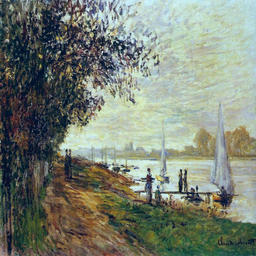

In [ ]:
nameA = os.listdir("/root/.keras/datasets/monet2photo/testA/")[0]
nameB = os.listdir("/root/.keras/datasets/monet2photo/testB/")[0]
imageA = np.array(Image.open(os.path.join("/root/.keras/datasets/monet2photo/testA/",nameA)))
imageB = np.array(Image.open(os.path.join("/root/.keras/datasets/monet2photo/testB/",nameB)))
imageA.shape,imageB.shape
imageA

array([[[  5,  68, 111],
        [  3,  67, 111],
        [  3,  67, 111],
        ...,
        [  0,  90, 141],
        [  0,  88, 138],
        [  0,  87, 137]],

       [[  6,  67, 111],
        [  6,  67, 111],
        [  6,  67, 111],
        ...,
        [  0,  89, 141],
        [  1,  89, 139],
        [  1,  87, 138]],

       [[ 11,  68, 113],
        [ 12,  69, 112],
        [ 15,  69, 113],
        ...,
        [  1,  89, 139],
        [  2,  88, 139],
        [  3,  86, 138]],

       ...,

       [[ 48,  52,  63],
        [ 48,  52,  63],
        [ 48,  52,  63],
        ...,
        [ 60,  69,  84],
        [ 60,  69,  84],
        [ 59,  68,  83]],

       [[ 44,  48,  60],
        [ 45,  49,  61],
        [ 46,  50,  62],
        ...,
        [ 59,  68,  83],
        [ 60,  67,  83],
        [ 60,  67,  83]],

       [[ 45,  49,  61],
        [ 45,  49,  61],
        [ 44,  48,  60],
        ...,
        [ 57,  64,  80],
        [ 58,  65,  81],
        [ 59,  66,  82]]], dtype=uint8)
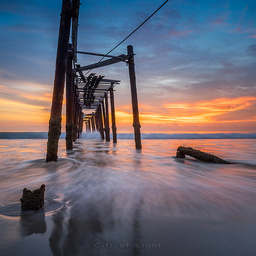

In [ ]:
imageB

In [ ]:
class MapDataset(Dataset):
    def __init__(self, root_dirA, root_dirB ,resize):
        self.root_dirA = root_dirA
        self.root_dirB = root_dirB
        self.list_filesA = os.listdir(self.root_dirA)
        self.list_filesB = os.listdir(self.root_dirB)
        self.both_transform = A.Compose(
            [A.Resize(width=resize, height=resize),], additional_targets={"image0": "image"},
        )

        self.transform_only_input = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(p=0.2),
                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
                ToTensorV2(),
            ]
        )

        self.transform_only_mask = A.Compose(
            [
                A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.list_filesA)

    def __getitem__(self, index):
        img_fileA = self.list_filesA[index]
        img_pathA = os.path.join(self.root_dirA, img_fileA)
        input_image = np.array(Image.open(img_pathA))

        img_fileB = self.list_filesB[index]
        img_pathB = os.path.join(self.root_dirB, img_fileB)
        target_image = np.array(Image.open(img_pathB))

        # augmentations = config.both_transform(image=input_image, image0=target_image)
        # input_image = augmentations["image"]
        # target_image = augmentations["image0"]

        input_image = self.transform_only_input(image=input_image)["image"]
        target_image = self.transform_only_mask(image=target_image)["image"]

        return input_image, target_image

In [ ]:
#test MapDataset class
train_dataset = MapDataset("/root/.keras/datasets/monet2photo/trainA/","/root/.keras/datasets/monet2photo/trainB/",256)
train_loader = DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True,
    )
# next(iter(train_loader))[0]

# Config and Utils

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image

torch.backends.cudnn.benchmark = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_A_DIR = "/root/.keras/datasets/monet2photo/trainA"
TRAIN_B_DIR = "/root/.keras/datasets/monet2photo/trainB"
VAL_A_DIR = "/root/.keras/datasets/monet2photo/testA"
VAL_B_DIR = "/root/.keras/datasets/monet2photo/testB"
LEARNING_RATE = 1e-5
BATCH_SIZE = 1
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
SAVE_IMG_DIR = "/content/saved_images"
if not os.path.exists(SAVE_IMG_DIR):
  os.makedirs(SAVE_IMG_DIR)
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_GEN_G = "gen_g.pth.tar"
CHECKPOINT_DISC_Y = "disc_y.pth.tar"
CHECKPOINT_GEN_F = "gen_f.pth.tar"
CHECKPOINT_DISC_X = "disc_x.pth.tar"

# def save_some_examples(gen, val_loader, epoch, folder):
#     x, y = next(iter(val_loader))
#     x, y = x.to(DEVICE), y.to(DEVICE)
#     gen.eval()
#     with torch.no_grad():
#         y_fake = gen(x)
#         y_fake = y_fake * 0.5 + 0.5  # remove normalization#
#         save_image(y_fake, folder + f"/y_gen_{epoch}.png")
#         save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
#         if epoch == 1:
#             save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
#     gen.train()

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Training Loop

In [ ]:
def train_fn(
   gen_G,disc_y,gen_F,disc_x, train_loader, opt_disc, opt_gen, l1_loss, mse, g_scaler, d_scaler,
):
    loop = tqdm(train_loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen_G(x)
            DiscG_real = disc_y(y)
            DiscG_fake = disc_y(y_fake.detach())
            DiscG_real_loss = mse(DiscG_real,torch.ones_like(DiscG_real))
            DiscG_fake_loss = mse(DiscG_fake,torch.zeros_like(DiscG_fake))
            DiscG_loss = (DiscG_real_loss + DiscG_fake_loss) / 2

            x_fake = gen_F(y)
            DiscF_real = disc_x(x)
            DiscF_fake = disc_x(x_fake.detach())
            DiscF_real_loss = mse(DiscF_real,torch.ones_like(DiscF_real))
            DiscF_fake_loss = mse(DiscF_fake,torch.zeros_like(DiscF_fake))
            DiscF_loss = (DiscF_real_loss + DiscF_fake_loss) / 2

            Disc_loss = (DiscF_loss+DiscG_loss)/2

        disc.zero_grad()
        d_scaler.scale(Disc_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():

            # ADV Loss
            # x_fake -> disc_x(x_fake) -> mse(disc_x(x_fake),1)
            # y_fake -> disc_y(y_fake) -> mse(disc_y(y_fake),1)
            DiscF_pred = disc_x(x_fake)
            X_Adv_loss = mse(DiscF_pred,torch.ones_like(DiscF_real))
            DiscG_pred = disc_y(y_fake)
            Y_Adv_loss = mse(DiscG_pred,torch.ones_like(DiscG_real))

            #Cycle Loss
            #X -> G(X) -> F(G(X)) -> X_cycle ====  y_fake -> gen_F(y_fake) -> x_cycle
            #Y -> F(Y) -> G(F(Y)) -> Y_cycle ====  x_fake -> gen_G(x_fake) -> y_cycle
            x_cycle = gen_F(y_fake)
            y_cycle = gen_G(x_fake)
            X_cycle_loss = l1_loss(x_cycle,x)
            Y_cycle_loss = l1_loss(y_cycle,y)

            #identity
            x_identity = gen_F(x)
            y_identity = gen_G(y)
            X_identity_loss = l1_loss(x_identity,x)
            Y_identity_loss = l1_loss(y_identity,y)

            #total
            Gen_loss = Y_cycle_loss + X_cycle_loss + Y_Adv_loss + X_Adv_loss + Y_identity_loss + X_identity_loss


        opt_gen.zero_grad()
        g_scaler.scale(Gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_loss=Disc_loss.item(),
                G_loss = Gen_loss.item(),
            )
        if idx % 200 == 0:
          save_image(x_fake * 0.5 + 0.5, f"saved_images/A_{idx}.png")
          save_image(y_fake * 0.5 + 0.5, f"saved_images/B_{idx}.png")


def main():
    gen_g = Generator(in_channels=3,res_layers=9,feature_g=64).to(DEVICE)
    disc_y = Discriminator(in_channels=3).to(DEVICE)
    gen_f = Generator(in_channels=3,res_layers=9,feature_g=64).to(DEVICE)
    disc_x = Discriminator(in_channels=3).to(DEVICE)
    opt_disc = optim.Adam(list(disc_x.parameters())+list(disc_y.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(list(gen_g.parameters())+list(gen_f.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999))
    MSE = nn.MSELoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_G, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC_Y, disc, opt_disc, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_F, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC_X, disc, opt_disc, LEARNING_RATE,
        )


    train_dataset = MapDataset(TRAIN_A_DIR,TRAIN_B_DIR,IMAGE_SIZE)
    train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
    val_dataset = MapDataset(VAL_A_DIR,VAL_B_DIR,IMAGE_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            gen_g,disc_y,gen_f,disc_x, train_loader, opt_disc, opt_gen, L1_LOSS, MSE, g_scaler, d_scaler
        )

        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen_g, opt_gen, filename=CHECKPOINT_GEN_G)
            save_checkpoint(disc_y, opt_disc, filename=CHECKPOINT_DISC_Y)
            save_checkpoint(gen_f, opt_gen, filename=CHECKPOINT_GEN_F)
            save_checkpoint(disc_x, opt_disc, filename=CHECKPOINT_DISC_X)

        # save_some_examples(gen, val_loader, epoch, folder=SAVE_IMG_DIR)

In [ ]:
main()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 3.06 MiB is free. Process 3861 has 14.74 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 145.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF